### TODO: 

- [x] Get classification from IPEDS as well, instead of using Scott Galloway's data
- [x] Get data for all years
- [x] Make plots, compute statistics for all minorities
- [ ] Make sure your filtered institutes are good and not leaving out any obvious ones. Maybe pick top 100 research unis and liberal art colleges
- [ ] Check for social mobility, and other outcome variables, specifically of minorities

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
from glob import glob
from scipy.stats import mannwhitneyu, ttest_ind
from tqdm import tqdm
import numpy as np 
%matplotlib inline

In [4]:
unis = pd.read_csv('../data/IPEDS/hd2020.csv',encoding='cp1252')
unis = unis[unis['C18BASIC'].apply(lambda x: x in [15, 16, 17, 21, 22])]
unis['Y']  = unis['C18BASIC'].apply(lambda x: 'liberal_arts' if x in [21, 22] else 'research')

In [5]:
## Preprocessing meta-data files
### Updating names to match in rankings  
unis.loc[unis['IALIAS']=='Virginia Tech', 'INSTNM'] = 'Virginia Tech'
unis.loc[unis['INSTNM']=='University of Illinois Urbana-Champaign', 'INSTNM'] = 'University of Illinois at Urbana-Champaign'
unis.loc[(unis['INSTNM']=="St. John's College") & (unis['STABBR']=='MD'), 'INSTNM'] = "St. John's College - MD"
unis.loc[(unis['INSTNM']=="St. John's College") & (unis['STABBR']=='NM'), 'INSTNM'] = "St. John's College - NM"
unis.loc[unis['INSTNM']=="William & Mary", 'INSTNM'] = "College of William and Mary"
unis.loc[(unis['INSTNM']=="Brigham Young University") & (unis['CITY']=='Provo'), 'INSTNM'] = "Brigham Young University-Provo"
unis.loc[(unis['INSTNM']=="The University of the South") & (unis['CITY']=='Sewanee'), 'INSTNM'] = "Sewanee - The University of the South"

In [6]:
rankings = pd.read_excel('../data/US Higher Education_ Value vs. Vulnerability.xlsx', skiprows=5,\
                         usecols=['Institution Name', 'Full Time Enrollment', 'Ranking List', 'Rank'])

rankings = rankings[rankings['Rank']<=100]
merged = pd.merge(unis, rankings, left_on='INSTNM', right_on='Institution Name')
set(rankings['Institution Name']).difference(merged['INSTNM'])

unis2 = merged[['UNITID', 'INSTNM', 'Y', 'HBCU']]

In [7]:
unis.groupby('HBCU').apply(lambda x: x['Y'].value_counts())

Y,liberal_arts,research
HBCU,,
1,45,11
2,483,401


In [8]:
# fnames = glob('../data/IPEDS/*_A/*_rv.csv')
# unitids = None
# for fname in fnames:
#     year = int(fname.split('/')[-1][1:-9])
#     data = pd.read_csv(fname, index_col=0)
#     cs = data[data['CIPCODE']==11.0701]
#     unitids = data.index if unitids is None else unitids.intersection(data.index)

In [10]:
women = ("women", "CTOTALW", "CRACE16")
black = ("black", "CBKAAT", "CRACE18")
hispanic = ("hispanic", "CHISPT", "CRACE21")
natives = ("natives", "CAIANT", "CRACE19")

results = {}

fnames = glob('../data/IPEDS/*_A/*_rv.csv')+glob('../data/IPEDS/*_a.csv')

for i, fname in enumerate(fnames):
    #print("%s/%s - %s" % (i, len(fnames), fname))
    year = int(fname.split('/')[-1].split('_')[0][1:])
    if year in [2000, 2001]:
        continue

    data = pd.read_csv(fname, index_col=0)
#     data = data[data['AWLEVEL']==5]
    data.columns = [col.upper() for col in data.columns]
    #cs = data[data['CIPCODE']==11.0701]
    cs = data[data['CIPCODE'].apply(lambda x: (x>=11) & (x<12))]
    cs.columns = [col.strip() for col in cs.columns]
    cs = cs.groupby(cs.index).sum()
    cs_cols = list(cs.columns)
    year_result = pd.DataFrame()
    for (label, var, var_alt) in [women, black, hispanic, natives]:
        if var in cs_cols:
            year_result["%s_%s" % (label, year)] = cs[var]/cs['CTOTALT']
        elif 'CRACE24' in cs_cols:
            #print("With CRACE26 - %s" % fname)
            year_result["%s_%s" % (label, year)] = cs[var_alt]/cs['CRACE24']
        else:
            #print("Without CRACE24 - %s" % fname)
            year_result["%s_%s" % (label, year)] = cs[var_alt]/(cs['CRACE15']+cs['CRACE16'])

    results[year] = year_result

## 1. Plotting - 1

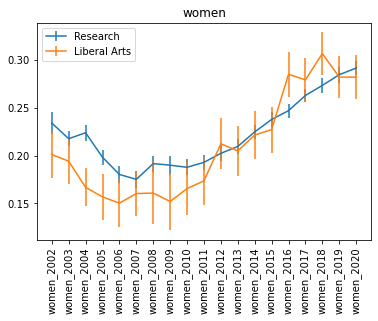

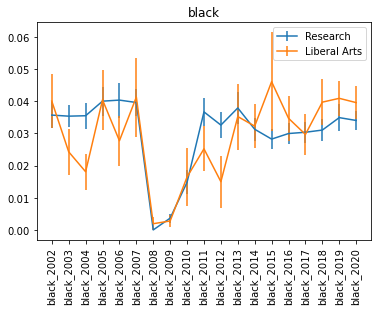

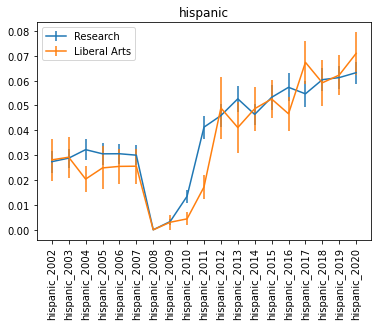

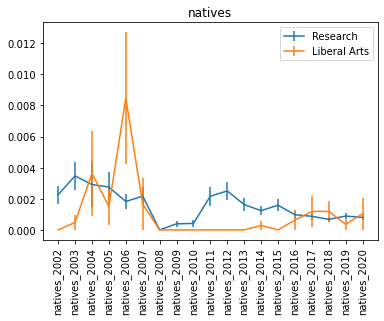

<Figure size 432x288 with 0 Axes>

In [167]:
years = list(results.keys())
commonids = set(results[years[0]].index)
for year in years[1:]:
    commonids = commonids.intersection(set(results[year].index))
    
all_years = pd.concat([results[year].loc[commonids] for year in years], axis=1)
merged = pd.merge(unis2, all_years, left_on='UNITID', right_index=True)

for (label, var, var_alt) in [women, black, hispanic, natives]:
    
    years_sorted = sorted([col for col in merged.columns if label in col])
    
    '''Filter for non-HBCUs and mixed gender schools'''
    filtered = merged[merged['HBCU']==2]
    filtered = filtered[filtered.apply(lambda x: np.all(x[years_sorted]==1)==False, axis=1)]
    
    means = filtered.groupby('Y').mean()[years_sorted]
    sems  = filtered.groupby('Y').sem()[years_sorted]

    plt.errorbar(x=years_sorted, y=means.loc['research'], yerr=sems.loc['research'])
    plt.errorbar(x=years_sorted, y=means.loc['liberal_arts'], yerr=sems.loc['liberal_arts'])
    plt.legend(['Research', 'Liberal Arts'])
    plt.xticks(rotation=90);
    plt.title(label)
    plt.figure();

## 2. Plotting - 2

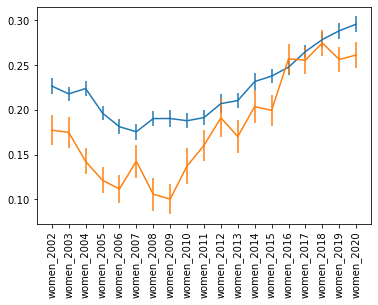

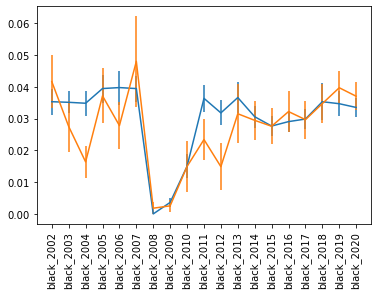

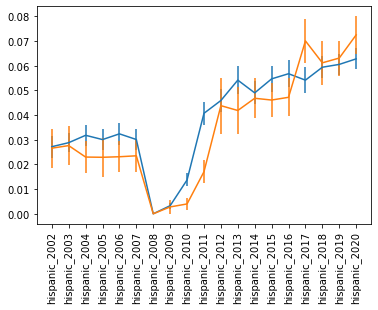

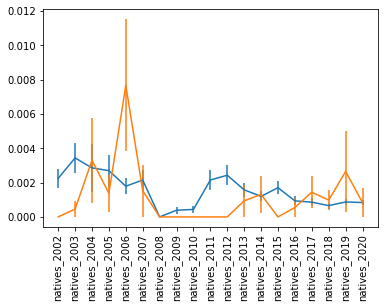

<Figure size 432x288 with 0 Axes>

In [168]:
for (label, var, var_alt) in [women, black, hispanic, natives]:
    
    means = pd.DataFrame()
    sems  = pd.DataFrame()
    
    for year in results.keys():
        merged = pd.merge(unis2, results[year], left_on='UNITID', right_index=True)
        years_sorted = sorted([col for col in merged.columns if label in col])
        '''Filter for non-HBCUs and mixed gender schools'''
        filtered = merged[merged['HBCU']==2]
        filtered = filtered[filtered.apply(lambda x: np.all(x[years_sorted]==1)==False, axis=1)]

        means[years_sorted] = filtered.groupby('Y').mean()[years_sorted]
        sems[years_sorted]  = filtered.groupby('Y').sem()[years_sorted]

    means = means.transpose().sort_index()
    sems  = sems.transpose().sort_index()

    plt.errorbar(x=means.index, y=means['research'], yerr=sems['research'])
    plt.errorbar(x=means.index, y=means['liberal_arts'], yerr=sems['liberal_arts'])
    plt.xticks(rotation=90);
    plt.figure();

## 3. Missing institutions

,Full Time Enrollment,Ranking List,Rank
Institution Name,,,
Princeton University,8267.0,USN National University Ranking,1.0
Claremont McKenna College,1324.0,USN National College Ranking,7.0
Davidson College,1843.0,USN National College Ranking,17.0
Bates College,1832.0,USN National College Ranking,21.0
Colorado College,2106.0,USN National College Ranking,27.0
Kenyon College,1721.0,USN National College Ranking,27.0
College of the Holy Cross,2913.0,USN National College Ranking,27.0
Scripps College,1063.0,USN National College Ranking,33.0
Pitzer College,1050.0,USN National College Ranking,35.0


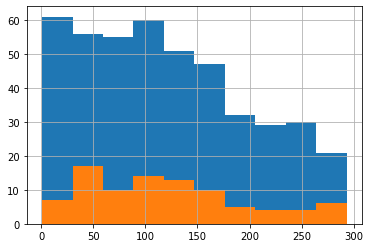

In [96]:
# a = dfs['women']
merged = pd.merge(rankings, merged, left_on='Institution Name', right_on='INSTNM')
missing = set(rankings['Institution Name']).difference(merged['INSTNM'])
missing_df = rankings.set_index('Institution Name').loc[missing].sort_values('Rank')
rankings['Rank'].hist()
missing_df['Rank'].hist()

missing_df[:10]

In [621]:
missing_unis = unis[unis['INSTNM'].apply(lambda x: x in missing)]
missing_unis = missing_unis[['UNITID', 'INSTNM']]

counts  = pd.DataFrame()
counts2 = pd.DataFrame()

In [632]:
set(years_sorted).difference(counts.columns)

{2003, 2020}

In [644]:
counts[year] = data.loc[missing_unis['UNITID'], 'CIPCODE'].apply(lambda x: x==11.0701).groupby('UNITID').sum()

2003

In [648]:
fnames = glob('../data/IPEDS/*_A/*_rv.csv')+glob('../data/IPEDS/*_a.csv')
for i, fname in enumerate(fnames):
    print("%s/%s - %s" % (i, len(fnames), fname))
    year = int(fname.split('/')[-1].split('_')[0][1:])
    if year in [2000, 2001, 2020]:
        continue
    data = pd.read_csv(fname, index_col=0)
    data.index.name = data.index.name.upper()
    data.columns = [col.upper() for col in data.columns]
    counts[year] = data.loc[missing_unis['UNITID'], 'CIPCODE'].apply(lambda x: x==11.0701).groupby('UNITID').sum()
    counts2[year] = data.loc[missing_unis['UNITID'], 'CIPCODE'].apply(lambda x: (x>=11) & (x<12)).groupby('UNITID').sum()

0/21 - ../data/IPEDS/C2009_A/c2009_a_rv.csv
1/21 - ../data/IPEDS/C2007_A/c2007_a_rv.csv
2/21 - ../data/IPEDS/C2017_A/c2017_a_rv.csv
3/21 - ../data/IPEDS/C2013_A/c2013_a_rv.csv
4/21 - ../data/IPEDS/C2019_A/c2019_a_rv.csv
5/21 - ../data/IPEDS/C2004_A/c2004_a_rv.csv
6/21 - ../data/IPEDS/C2014_A/c2014_a_rv.csv
7/21 - ../data/IPEDS/C2010_A/c2010_a_rv.csv
8/21 - ../data/IPEDS/C2005_A/c2005_a_rv.csv
9/21 - ../data/IPEDS/C2015_A/c2015_a_rv.csv
10/21 - ../data/IPEDS/C2011_A/c2011_a_rv.csv
11/21 - ../data/IPEDS/C2008_A/c2008_a_rv.csv
12/21 - ../data/IPEDS/C2006_A/c2006_a_rv.csv
13/21 - ../data/IPEDS/C2016_A/c2016_a_rv.csv
14/21 - ../data/IPEDS/C2018_A/c2018_a_rv.csv
15/21 - ../data/IPEDS/C2012_A/c2012_a_rv.csv


/Users/fahadsultan/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


16/21 - ../data/IPEDS/c2000_a.csv
17/21 - ../data/IPEDS/c2002_a.csv
18/21 - ../data/IPEDS/c2020_a.csv
19/21 - ../data/IPEDS/c2003_a.csv
20/21 - ../data/IPEDS/c2001_a.csv


In [657]:
counts2.apply(lambda x: np.any(x==0), axis=1).sum(), len(counts2)

(63, 66)

In [658]:
counts.apply(lambda x: np.any(x==0), axis=1).sum(), len(counts)

(66, 66)

In [662]:
unis.loc[unis['INSTNM']=='Davidson College', 'UNITID']

2412    198385
Name: UNITID, dtype: int64

In [663]:
counts.loc[198385]

2009    0
2007    0
2017    0
2013    0
2019    0
2004    0
2014    0
2010    0
2005    0
2015    0
2011    0
2008    0
2006    0
2016    0
2018    0
2012    0
2002    0
2003    0
Name: 198385, dtype: int64

In [664]:
counts2.loc[198385]

2009    0
2007    0
2017    2
2013    0
2019    2
2004    0
2014    0
2010    0
2005    0
2015    0
2011    0
2008    0
2006    0
2016    0
2018    2
2012    0
2002    0
2003    0
Name: 198385, dtype: int64

UNITID
107080    2
112260    2
120254    2
121150    1
121257    0
         ..
232672    3
233301    0
233718    2
237057    0
239017    0
Name: CIPCODE, Length: 66, dtype: int64

In [618]:
a

,CIPCODE,MAJORNUM,AWLEVEL,XCNRALM,CNRALM,XCNRALW,CNRALW,XCRACE03,CRACE03,XCRACE04,...,XDVCHSM,DVCHSM,XDVCHSW,DVCHSW,XDVCWHT,DVCWHT,XDVCWHM,DVCWHM,XDVCWHW,DVCWHW
UNITID,,,,,,,,,,,,,,,,,,,,,
107080,3.0103,1,5,Z,0,Z,0,Z,0.0,Z,...,Z,0,Z,0,R,5,R,1,R,4
107080,11.0701,1,5,R,1,Z,0,Z,0.0,Z,...,Z,0,Z,0,R,7,R,7,Z,0
107080,11.0701,2,5,Z,0,Z,0,Z,0.0,Z,...,Z,0,Z,0,R,1,R,1,Z,0
107080,13.1202,1,5,Z,0,Z,0,Z,0.0,Z,...,Z,0,Z,0,R,2,Z,0,R,2
107080,16.0501,1,5,R,0,Z,0,Z,0.0,Z,...,Z,0,Z,0,Z,0,Z,0,Z,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239017,50.0904,2,5,Z,0,Z,0,Z,0.0,Z,...,Z,0,Z,0,Z,0,Z,0,Z,0
239017,54.0101,1,5,Z,0,Z,0,Z,0.0,Z,...,Z,0,Z,0,R,12,R,7,R,5
239017,54.0101,2,5,Z,0,Z,0,Z,0.0,Z,...,Z,0,Z,0,Z,0,Z,0,Z,0


In [619]:
a

UNITID
107080    2
112260    2
120254    2
121150    1
121257    0
         ..
232672    3
233301    0
233718    2
237057    0
239017    0
Name: CIPCODE, Length: 66, dtype: int64

In [ ]:
data.loc[missing_unis['UNITID']].groupby

In [ ]:

if var in cs_cols:
    ratios[year] = cs[var]/cs['CTOTALT']
elif 'CRACE24' in cs_cols:
    #print("With CRACE26 - %s" % fname)
    ratios[year] = cs[var_alt]/cs['CRACE24']
else:
    #print("Without CRACE24 - %s" % fname)
    ratios[year] = cs[var_alt]/(cs['CRACE15']+cs['CRACE16'])
